In [98]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor



In [99]:
# Fetch ExxonMobil's stock data and S&P (GSPC) data from Yahoo Finance
start = datetime(2000, 1, 1)  # Start date
end = datetime.now()  # Retrieves data up to the current date
df_xom = yf.download('XOM', start, end)
df_sp500 = yf.download('^GSPC', start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [100]:
# Calculate the 50-day moving average for XOM
df_xom['50_MA'] = df_xom['Close'].rolling(window=50).mean()

# Combine S&P 500 data with XOM data
df_combined = df_xom[['Close', 'Volume', '50_MA']].copy()
df_combined['SP500'] = df_sp500['Close']

# Remove NaN values (initially, there will be NaN values for the 50-day MA)
df_combined.dropna(inplace=True)

In [101]:
# Convert dates to datetime objects
df_combined.reset_index(inplace=True)
df_combined.rename(columns={'index': 'Date'}, inplace=True)

# Split the data into training and testing sets
train_size = int(len(df_combined) * 0.8)
train_set = df_combined.iloc[:train_size]
test_set = df_combined.iloc[train_size:]

In [102]:
# Normalize features using standard scaler
scaler = StandardScaler()
train_features = ['Volume', '50_MA', 'SP500']
X_train = scaler.fit_transform(train_set[train_features])
y_train = train_set['Close']
X_test = scaler.transform(test_set[train_features])
y_test = test_set['Close']

In [103]:

# Use a simpler model with regularization
linear_model = Ridge(alpha=1.0)  # Alpha is a regularization parameter

# Walk-forward validation setup
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store the results of walk-forward validation
walk_forward_predictions = []
actual_values = []

# Perform walk-forward validation
for train_index, test_index in tscv.split(X_train):
    # Split data
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Fit the model
    linear_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    predictions_fold = linear_model.predict(X_test_fold)
    walk_forward_predictions.extend(predictions_fold)
    
    # Store actual values
    actual_values.extend(y_test_fold)
    
#Train the model on the entire training set
linear_model.fit(X_train, y_train)

Ridge()

In [104]:
# Evaluate the model
mse_walk_forward = mean_squared_error(actual_values, walk_forward_predictions)
print(f"Walk-Forward Validation MSE: {mse_walk_forward}")

Walk-Forward Validation MSE: 12.81757111353174


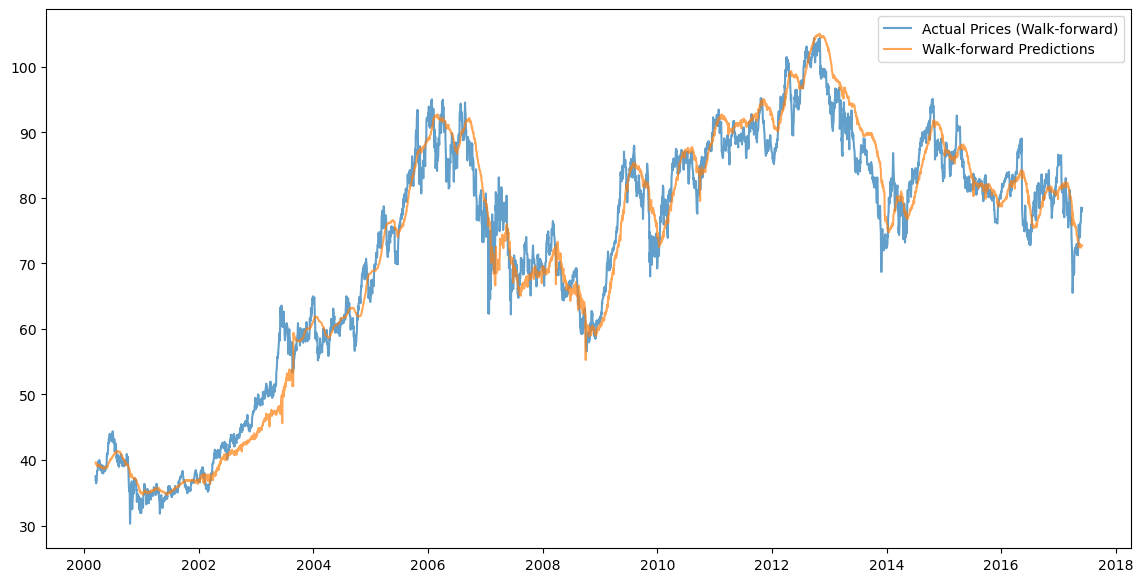

In [105]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_combined['Date'][:len(actual_values)], actual_values, label='Actual Prices (Walk-forward)', alpha=0.7)
plt.plot(df_combined['Date'][:len(walk_forward_predictions)], walk_forward_predictions, label='Walk-forward Predictions', alpha=0.7)
plt.legend()
plt.show()

In [106]:
# Prepare the feature set for March 1, 2024, using the last known data
last_features = df_combined[train_features].iloc[-1].values.reshape(1, -1)

# Apply the same scaling as was done for the training data
# last_scaled_features = scaler.transform(last_features)

# Predict the price for March 1, 2024 using the trained Ridge model
predicted_future_price = linear_model.predict(last_scaled_features)
print(f"Predicted stock price for XOM on March 1, 2024: ${predicted_future_price[0]:.2f}")

Predicted stock price for XOM on March 1, 2024: $108.88
